In [13]:
import scipy as scipy
from sklearn import cluster
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi
import pandas as pd
import pixiedust
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import time

Pixiedust database opened successfully


# 1-Reading Data from a Dataset of Genes: 
Source: http://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq
Clustering is Unsupervised, But labels were available. Reading labels can help comparing the result.
Evaluation is done in three ways:
    -Checking with labels file
    -Using PCA to visualize how well it works
    -Using Embeded Library to compare

In [14]:
df = pd.read_csv (r'nhdata.csv',header=None)   #'r' before the path string to address any special characters, such as '\'
lf = pd.read_csv (r'nhlabels.csv',header=None)  
lf.head(3)
#for data.csv read:
#lf=lf.iloc[1:,1:] 
#df=df.iloc[1:,1:]
#df=df.values #to remove nonvalues
#lf=lf.values

,0
0,1
1,2
2,1


# 2-Preparation
Then we obtain Data and Labels file's arrays and prepare them with Reshape and Centering

In [15]:
#%%pixie_debugger
#for READING FROM DATAFRAMES
nx,dx=np.shape(df)
print("Data: rows={0}, columns={1}".format(nx,dx))
Xarr=np.array(df)

ny,dy=np.shape(lf)
print("Labels: rows={0}, columns={1}".format(ny,dy))
Yarr=np.array(lf)

#Y=np.matrix.flatten(Y)
Y=np.reshape(Yarr,(ny,)) #only in order to be assigned to colors in plot
#for data.csv read:
#Y=pd.factorize(Y)

Data: rows=801, columns=16383
Labels: rows=801, columns=1


In [21]:
def Centering(Xarr):
    X  = Xarr - np.mean(Xarr)
    return X

# 3-Funtions of DBSCAN
First,We need to compute the distance between each point and others

In [22]:
def euclidDistance(P1,P2):
    return np.linalg.norm(P1-P2,2)
def allDistances(X1, X2):
    D = np.zeros((X1.shape[0], X2.shape[0]))
    for idx1 in range(len(X1)):
        for idx2 in range(len(X2)):
            D[idx1,idx2] = euclidDistance(X1[idx1,:],X2[idx2,:])
    return D

Then, call it to determine each POINT's type: CORE,BORDER,OUTLIER. If a point is a core, There will be a cluster! containing itself and neighbors. It also merges with all other clusters in its neighborhood. If it's not, maybe it is a noise, or maybe a border. that depends on whether it will be reached by one core or not. this is done by the pseudocode below:

In [29]:
def MyDBSCAN(Dataset, Eps, MinPoint):
    smpl=len(Dataset)
    visited=np.zeros(smpl)
    CBO=np.full(smpl,3) #C=Core:0, B=Border:1"Defult", O=Outlier:2
    whichC=np.zeros(smpl) #undecided Cluster=0
    c=1 #first cluster
    N=[]
    dist=allDistances(Dataset,Dataset)
    for P in range(smpl):
        if visited[P]==0: #only if not reached(yet) by others
            visited[P]=1
            N=np.where(dist[P]<Eps)[0] #It gives a list of all neighbors' ids(column num) having condition
            # To explain: for ith sample, each column of dist represents i distance with i,i+1,i+2 th sample
            if len(N)<MinPoint:
                CBO[P]=2 #OUTLIER for now. until whichC determined
            else:
                CBO[P]=0 #CORE
                c=c+1
                whichC[P]=c                
                N=N.tolist()
                MyExpandClsuter(N,MinPoint,Eps,visited,dist,whichC,c,CBO)
    CheckOutlier(smpl,N,MinPoint,Eps,visited,dist,whichC,CBO)
    #print(CBO) #Turn it on to see the nature of each point
    return whichC

In [24]:
def MyExpandClsuter(N,MinPoint,Eps,visited,dist,whichC,c,CBO):
    Nprim=[]
    for Pprim in N:
        if CBO[Pprim]!=0:
            CBO[Pprim]= 1 #BORDER for now. it may be a border or a core LEMMA 3:density reachable
        if visited[Pprim]==0: #P itself won't be visited again although it is in the set    
            visited[Pprim]=1
            Nprim=np.where(dist[Pprim]<Eps)[0]
            if len(Nprim)>=MinPoint: #so it is a core next to this core=>merge with this one
                CBO[Pprim]=0 #CORE
                for i in Nprim:
                    N.append(i)                
        if whichC[Pprim]==0: 
            whichC[Pprim]=c
    return

After having all the points visited, there may still be some points "DENSITY CONNECTED" to others. It is CBO's job to cluster them
This part was not included in my sources but I found it necessary

In [25]:
def CheckOutlier(smpl,N,MinPoint,Eps,visited,dist,whichC,CBO):
    for rep in range(MinPoint-1): #There is a posibility of being connected through a MinPoint-1 chain 
        for allp in range (smpl):
            if CBO[allp]==2:
                M=np.where(dist[allp]<Eps)[0]
                for allm in M:
                    if CBO[allm]!=2: #Neighbor is Border or Core=> point is reachable
                            CBO[allp]=1 #false Outlier is a Border
                            whichC[allp]=whichC[allm]

# 4-Calling DBSCAN to do Clustering
plotting the clusters determined by DBSCAN
and plotting the clusters determined by labels file.
just to compare with eye.
Parameters(Minimum Points and Epsilon) of this algorithm are set to 7 and 9 as these numbers work better! 

### To visualize what is going on and also enable computing
using PCA to reduce dimension so that we can see how clustering works

after Centering and Dimension Reduction, rows =801, columns=2
8.218470335006714


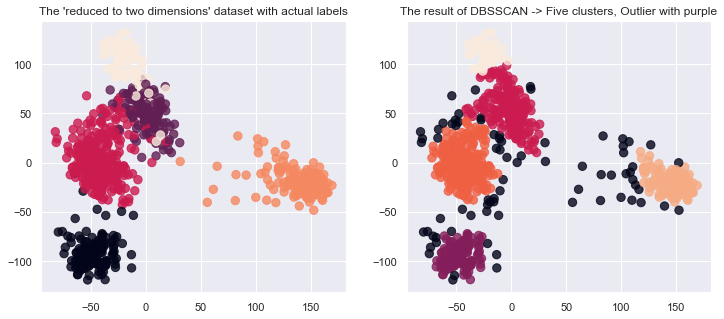

In [30]:
start = time.time()
X=Centering(Xarr)

pca = PCA(n_components=2)
X = pca.fit_transform(X)
nfinal,dfinal=(X.shape)
print("after Centering and Dimension Reduction, rows ={0}, columns={1}".format(nfinal,dfinal))

result=MyDBSCAN(X,7,9) 
fig=plt.figure(figsize=(12,5))
a1=fig.add_subplot(1,2,1)
a2=fig.add_subplot(1,2,2)
a1.scatter(X[:,0], X[:,1], s=70, c=Y, alpha=0.8)
a1.set_title("The 'reduced to two dimensions' dataset with actual labels")
a2.scatter(X[:,0], X[:,1], s=70, c=result, alpha=0.8)
a2.set_title("The result of DBSSCAN -> Five clusters, Outlier with purple")
print (time.time()- start)

We can see that Minimum Points and Epsilon above work better here. There are some iterations provided with different parameters: It takes a while

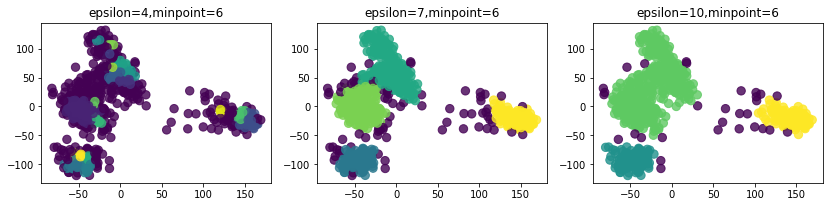

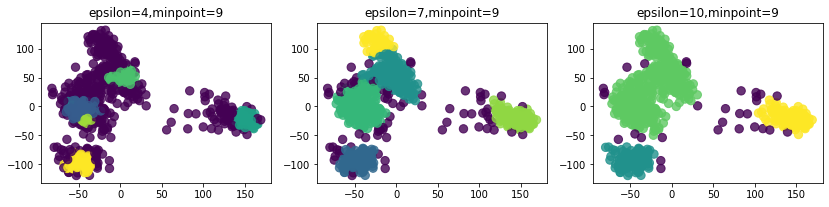

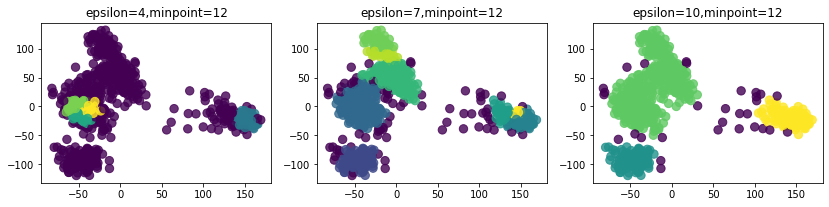

In [14]:
Eps=[4,7,10]
Minp=[6,9,12]
cols=len(Eps)
rows=len(Minp)
i=0
while i<= (len(Minp)*len(Eps)-3):
    fig=plt.figure(figsize=(14,10))
    a1=fig.add_subplot(rows,cols,i+1)
    a2=fig.add_subplot(rows,cols,i+2)
    a3=fig.add_subplot(rows,cols,i+3)
    resultc1 =MyDBSCAN(X,Eps[0],Minp[i//3]) 
    resultc2 =MyDBSCAN(X,Eps[1],Minp[i//3]) 
    resultc3 =MyDBSCAN(X,Eps[2],Minp[i//3])
    a1.scatter(X[:,0], X[:,1], s=70, c=resultc1, alpha=0.8)
    a2.scatter(X[:,0], X[:,1], s=70, c=resultc2, alpha=0.8)
    a3.scatter(X[:,0], X[:,1], s=70, c=resultc3, alpha=0.8)
    a1.set_title("epsilon={0},minpoint={1}".format(Eps[0],Minp[i//3]))
    a2.set_title("epsilon={0},minpoint={1}".format(Eps[1],Minp[i//3]))
    a3.set_title("epsilon={0},minpoint={1}".format(Eps[2],Minp[i//3]))
    i+=3

# Test for more dimensions:
the result is more acceptable with Minpoints: 20 and Epsilon:19

after Centering and Dimension Reduction, rows =801, columns=3


Text(0.5, 0.92, 'The result of DBSSCAN -> Five clusters, Outlier with purple')

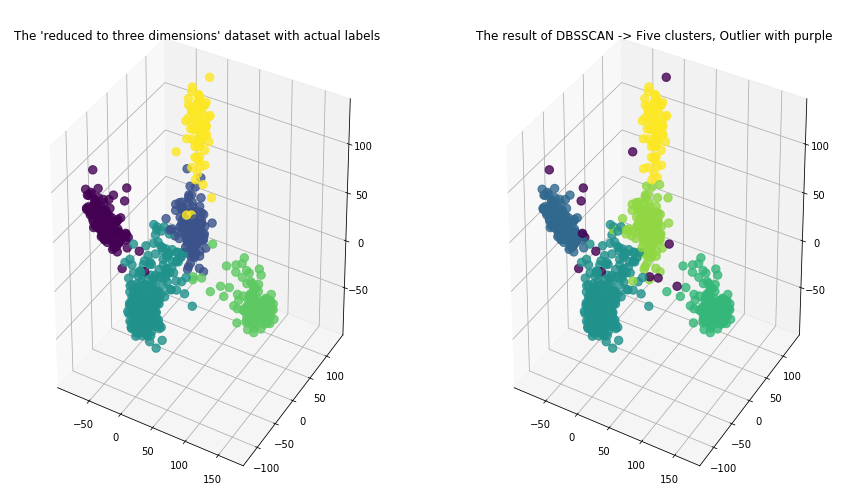

In [16]:
X=Centering(Xarr)

pca = PCA(n_components=3)
X = pca.fit_transform(X)
nfinal,dfinal=(X.shape)
print("after Centering and Dimension Reduction, rows ={0}, columns={1}".format(nfinal,dfinal))

result=MyDBSCAN(X,20,19) 
fig=plt.figure(figsize=(15,9))
a1=fig.add_subplot(1,2,1, projection="3d")
a2=fig.add_subplot(1,2,2, projection="3d")
a1.scatter3D(X[:,0], X[:,1], X[:,2], s=70, c=Y, alpha=0.8)
a1.set_title("The 'reduced to three dimensions' dataset with actual labels")
a2.scatter3D(X[:,0], X[:,1], X[:,2], s=70, c=result, alpha=0.8)
a2.set_title("The result of DBSSCAN -> Five clusters, Outlier with purple")

# Call for Spiral Data To Check the Efficienciy:

In [17]:
#for SPIRAL DATA GENERATION (generate,save,load): Note that there is no label matrix here

N = 400
theta = np.sqrt(np.random.rand(N))*2*np.pi # np.linspace(0,2*pi,100)

r_a = 4*theta +np. pi
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
x_a = data_a + np.random.randn(N,2)

r_b = -4*theta - np.pi
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
x_b = data_b + np.random.randn(N,2)

res_a = np.append(x_a, np.zeros((N,1)), axis=1)
res_b = np.append(x_b, np.ones((N,1)), axis=1)

res = np.append(res_a, res_b, axis=0)
np.random.shuffle(res)

np.savetxt("spiraldataset.csv", res, delimiter=",", comments="", fmt='%.5f')

Spiralf = pd.read_csv (r'spiraldataset.csv',header=None)

nx,dx=np.shape(Spiralf)
sf=np.array(Spiralf)
Xarr=sf[:,:2]
Y=sf[:,2]
print("X: rows={0},columns={1}".format(len(Xarr),len(Xarr[0])))
print("Y: rows={0}".format(len(Y)))

X: rows=800,columns=2
Y: rows=800


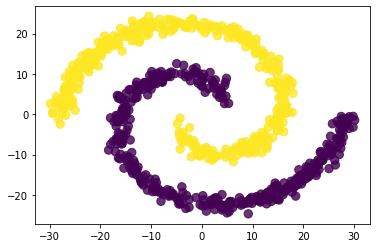

In [18]:
#print the Spiral Generated data with 
X=Centering(Xarr)
plt.scatter(X[:,0], X[:,1], s=70, c=Y, alpha=0.8)


This method solves spiral and cluster in cluster datasets better than mean-shift,  k-means , and many other. 

Text(0.5, 1.0, 'epsilon=3,minpoint=4')

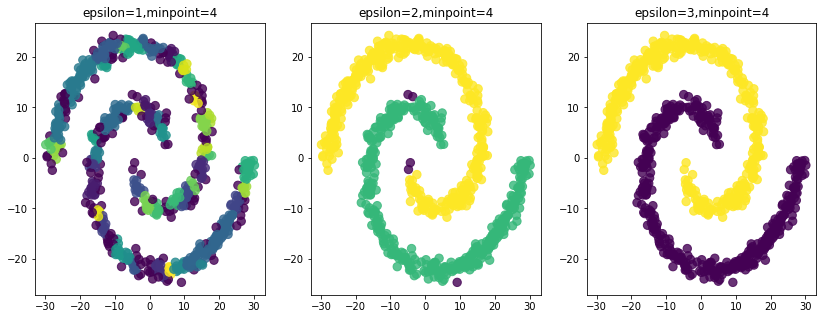

In [19]:
Eps=[1,2,3] 
Minp=4
fig=plt.figure(figsize=(14,5))
a1=fig.add_subplot(1,3,1)
a2=fig.add_subplot(1,3,2)
a3=fig.add_subplot(1,3,3)
resultc1 =MyDBSCAN(X,Eps[0],Minp) 
resultc2 =MyDBSCAN(X,Eps[1],Minp) 
resultc3 =MyDBSCAN(X,Eps[2],Minp)
a1.scatter(X[:,0], X[:,1], s=70, c=resultc1, alpha=0.8)
a2.scatter(X[:,0], X[:,1], s=70, c=resultc2, alpha=0.8)
a3.scatter(X[:,0], X[:,1], s=70, c=resultc3, alpha=0.8)
a1.set_title("epsilon={0},minpoint={1}".format(Eps[0],Minp))
a2.set_title("epsilon={0},minpoint={1}".format(Eps[1],Minp))
a3.set_title("epsilon={0},minpoint={1}".format(Eps[2],Minp))

# To make a comparison between the built in library and the implemented code
the library is imported and the output is visualized. The same answer with the same parameters is obtained. I copy pasted the dataset preparation from the first part of notebook to be close together with other cells. The for loops that I added to my code as "CheckOutlier" function made my code work better in this case. but it can be removed from the process that results in an outcome more similar to the library one's.

In [15]:
#%%pixie_debugger
#for READING FROM DATAFRAMES
nx,dx=np.shape(df)
print("Data: rows={0}, columns={1}".format(nx,dx))
Xarr=np.array(df)

ny,dy=np.shape(lf)
print("Labels: rows={0}, columns={1}".format(ny,dy))
Yarr=np.array(lf)

#Y=np.matrix.flatten(Y)
Y=np.reshape(Yarr,(ny,)) #only in order to be assigned to colors in plot
#for data.csv read:
#Y=pd.factorize(Y)

Data: rows=801, columns=16383
Labels: rows=801, columns=1


after Centering and Dimension Reduction, rows =801, columns=2
1.0500600337982178


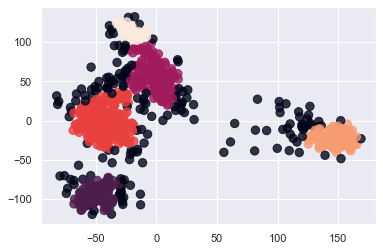

In [19]:
start = time.time()

X=Centering(Xarr)

pca = PCA(n_components=2)
X = pca.fit_transform(X)
nfinal,dfinal=(X.shape)
print("after Centering and Dimension Reduction, rows ={0}, columns={1}".format(nfinal,dfinal))
m = DBSCAN(eps=7, min_samples=9)
m.fit(X)
clusters = m.labels_
plt.scatter(X[:,0], X[:,1], s=70, c=clusters, alpha=0.8)
print (time.time()- start)